# Day 4, part 2: Outbreak estimates

<div style="background: #f8f9fa; padding: 0.5rem 1rem; border-radius: 8px; margin-bottom: 1rem; border-left: 4px solid #007bff;">
<a href="../../index.ipynb" style="text-decoration: none; color: #007bff; font-weight: bold;">← Back to Course Index</a> | 
<a href="../../index-tr.ipynb" style="text-decoration: none; color: #dc3545; font-weight: bold;">🇹🇷 Türkçe Index</a>
</div>

---

## Introduction

This practical is the second (out of two) part of a practical which simulates the early assessment and reconstruction of an Ebola Virus Disease (EVD) outbreak. 
Please make sure you have gone through **part 1** before starting **part 2**. 
In **part 2** of the practical, we introduce various aspects of analysis of the early stage of an outbreak, including growth rate estimation, contact tracing data, delays, and estimates of transmissibility. 


## Learning outcomes

By the end of this practical **part 2**, you should be able to:

- Estimate & interpret the growth rate & doubling time of the epidemic

- Estimate the serial interval from data on pairs infector / infected individuals

- Estimate & interpret the reproduction number of the epidemic

- Forecast short-term future incidence

## Context: A novel EVD outbreak in a fictional country in West Africa

A new EVD outbreak has been notified in a fictional country in West Africa. The Ministry of Health is in charge of coordinating the outbreak response, and have contracted you as a consultant in epidemic analysis to inform the response in real time. You have already read in an done descriptive analysis of the data (**part 1** of the practical). Now let's do some statistical analyses! 

## Required packages 

The following packages, available on CRAN or github, are needed for this analysis.
You should have installed them in **part 1** but if not, install necessary packages as follows:

Once the packages are installed, you may need to open a new R session. Then load the libraries as follows:

In [ ]:
library(readxl)
library(outbreaks)
library(incidence)
library(epicontacts)
library(distcrete)
library(epitrix)
library(EpiEstim)
library(projections)
library(ggplot2)
library(magrittr)
library(binom)
library(ape)
library(outbreaker2)
library(here)

## Read in the data processed in [part 1](./real-time-response-1.html)

<!--
ZNK: These two chunks are needed because of the way the documents are structured
in blogdown. The source that we edit is not the same as the site that is
rendered. Everything in this directory will end up in the same directory as the
"static" when the website is displayed, but the current directory structure is
present when the practicals are built, so we have to do this silly 
song-and-dance to appease the directory gods.
-->

In [34]:
i_daily <- readRDS(here("data/clean/i_daily.rds"))
i_weekly <- readRDS(here("data/clean/i_weekly.rds"))
linelist <- readRDS(here("data/clean/linelist.rds"))
linelist_clean <- readRDS(here("data/clean/linelist_clean.rds"))
contacts <- readRDS(here("data/clean/contacts.rds"))

## Estimating the growth rate using a log-linear model

The simplest model of incidence is probably the log-linear model, i.e. a linear 
regression on log-transformed incidences. 
For this we will work with weekly incidence, to avoid having
too many issues with zero incidence (which cannot be logged). 

Visualise the log-transformed incidence:

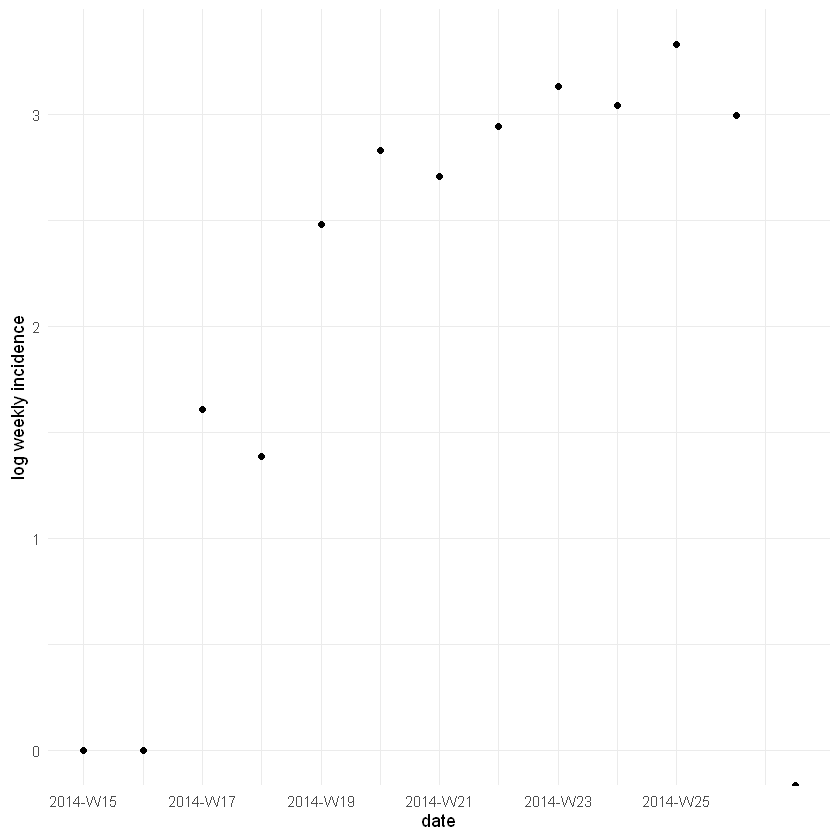

In [35]:
ggplot(as.data.frame(i_weekly)) + 
  geom_point(aes(x = dates, y = log(counts))) + 
  scale_x_incidence(i_weekly) +
  xlab("date") +
  ylab("log weekly incidence") + 
  theme_minimal()

What does this plot tell you about the epidemic?   

In the `incidence` package, the function `fit` will estimate the parameters of this model from an incidence object (here, `i_weekly`). Apply it to the data and store the result in a new object called `f`. You can print and use `f` to derive estimates of the growth rate r and the doubling time, and add the corresponding model to the incidence plot:  

Fit a log-linear model to the weekly incidence data:  

Warning message in incidence::fit(i_weekly):
"1 dates with incidence of 0 ignored for fitting"


<incidence_fit object>

$model: regression of log-incidence over time

$info: list containing the following items:
  $r (daily growth rate):
[1] 0.04145251

  $r.conf (confidence interval):
          2.5 %     97.5 %
[1,] 0.02582225 0.05708276

  $doubling (doubling time in days):
[1] 16.72148

  $doubling.conf (confidence interval):
        2.5 %   97.5 %
[1,] 12.14285 26.84302

  $pred: data.frame of incidence predictions (12 rows, 5 columns)

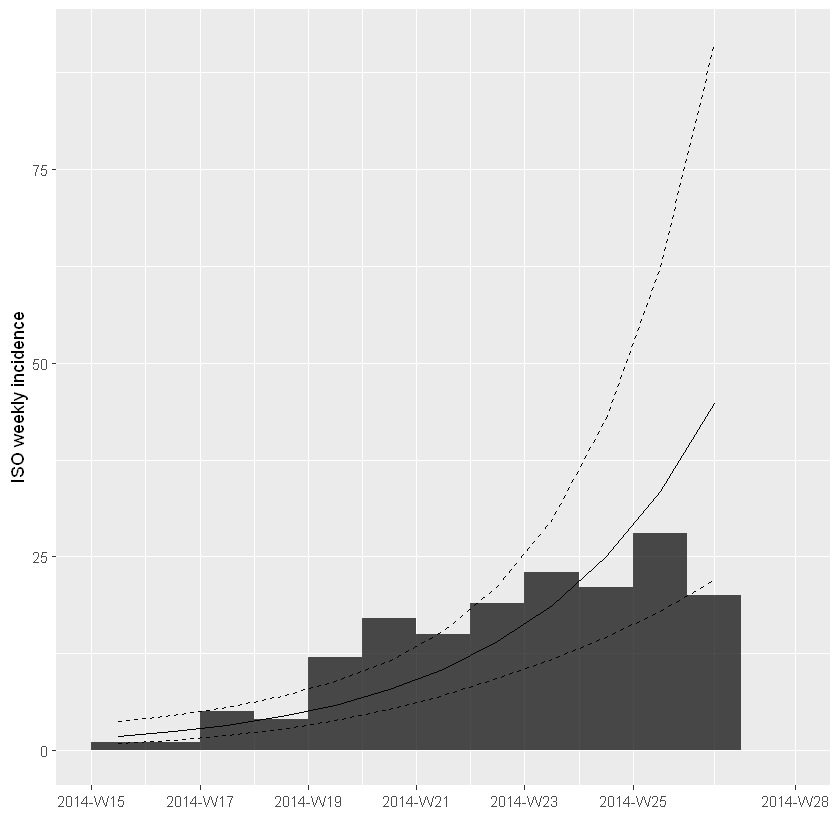

In [36]:
f <- incidence::fit(i_weekly)
f
plot(i_weekly, fit = f)

Looking at the plot and fit, do you think this is a reasonable fit?   

## Finding a suitable threshold date for the log-linear model, based on the observed delays

Using the plot of the log(incidence) that you plotted above, and thinking about why exponential growth may not be observed in the most recent weeks, choose a threshold date and fit the log-linear model to a suitable section of the epicurve where you think we can more reliably estimate the growth rate, r, and the doubling time.  

You may want to examine how long after onset of symptoms cases are hospitalised; 
this may inform the threshold date you choose, as follows:  

In [37]:
summary(as.numeric(linelist_clean$date_of_hospitalisation - linelist_clean$date_of_onset))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    2.00    3.53    5.00   22.00 

In [38]:
cat("- Assuming that cases are only ever reported on or after hospitalisation, we see that it takes on average 4 days for cases to be hospitalised, but up to 22 days, so delays in reporting can be long, and it's sensible to assume that the last 2-3 weeks of data are likely to be incomplete.")

- Assuming that cases are only ever reported on or after hospitalisation, we see that it takes on average 4 days for cases to be hospitalised, but up to 22 days, so delays in reporting can be long, and it's sensible to assume that the last 2-3 weeks of data are likely to be incomplete.

In [39]:

cat("- Exponential growth is observed only up until early to early to mid-June\n")  
cat("- This is likely due to the delay between onset and reporting. This means that the cases with most recent onset have not been reported and are missing from the linelist\n")  
cat("- This can result in potentially erroneous interpretation of the recent trends in incidence when just looking at the epicurve.\n")  


- Exponential growth is observed only up until early to early to mid-June
- This is likely due to the delay between onset and reporting. This means that the cases with most recent onset have not been reported and are missing from the linelist
- This can result in potentially erroneous interpretation of the recent trends in incidence when just looking at the epicurve.


In [40]:
# how many weeks should we discard at the end of the epicurve
n_weeks_to_discard <- 2

In [41]:
min_date <- min(i_daily$dates)
max_date <- max(i_daily$dates) - n_weeks_to_discard * 7
# weekly truncated incidence
i_weekly_trunc <- subset(i_weekly, 
                         from = min_date, 
                         to = max_date) # discard last few weeks of data
# daily truncated incidence (not used for the linear regression but may be used later)
i_daily_trunc <- subset(i_daily, 
                         from = min_date, 
                         to = max_date) # remove last two weeks of data

Refit and plot your log-linear model as before but using the truncated data `i_weekly_trunc`. 

<incidence_fit object>

$model: regression of log-incidence over time

$info: list containing the following items:
  $r (daily growth rate):
[1] 0.04773599

  $r.conf (confidence interval):
          2.5 %     97.5 %
[1,] 0.03141233 0.06405965

  $doubling (doubling time in days):
[1] 14.52043

  $doubling.conf (confidence interval):
        2.5 %   97.5 %
[1,] 10.82034 22.06609

  $pred: data.frame of incidence predictions (11 rows, 5 columns)

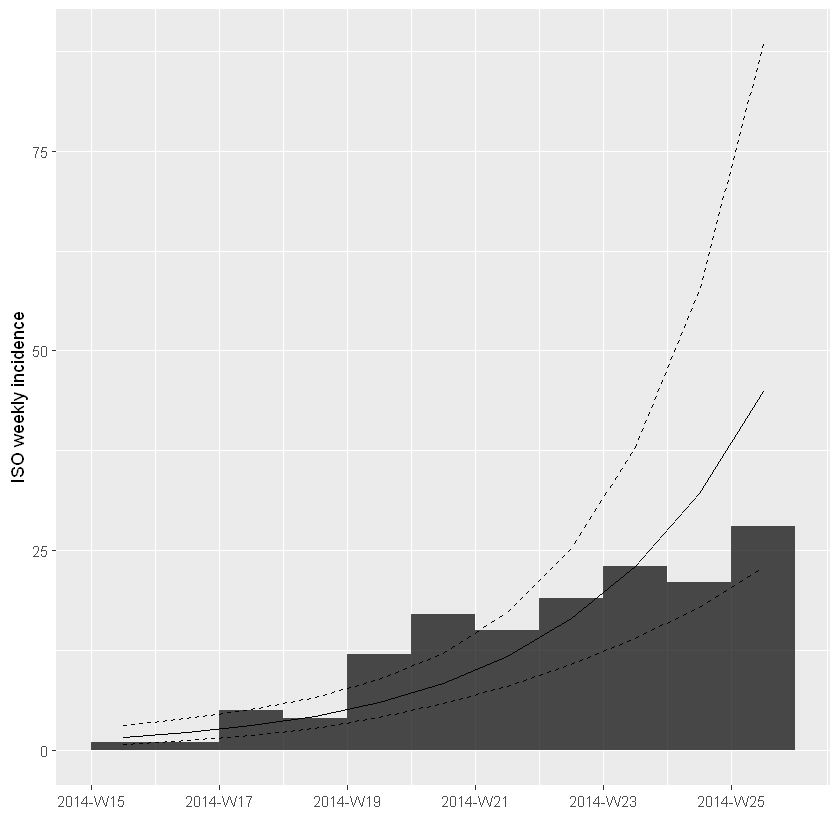

In [42]:
f <- incidence::fit(i_weekly_trunc)
f
plot(i_weekly_trunc, fit = f)

Look at the summary statistics of your fit:

In [43]:
summary(f$model)


Call:
stats::lm(formula = log(counts) ~ dates.x, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.79781 -0.44508 -0.00138  0.35848  0.69880 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.296579   0.320461   0.925    0.379    
dates.x     0.047736   0.007216   6.615 9.75e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5298 on 9 degrees of freedom
Multiple R-squared:  0.8294,	Adjusted R-squared:  0.8105 
F-statistic: 43.76 on 1 and 9 DF,  p-value: 9.754e-05


You can look at the goodness of fit (Rsquared), the estimated slope (growth rate)
and the corresponding doubling time as below:  

In [44]:
# does the model fit the data well? 
adjRsq_model_fit <- summary(f$model)$adj.r.squared
# what is the estimated growth rate of the epidemic?
daily_growth_rate <- f$model$coefficients['dates.x']
# confidence interval:
daily_growth_rate_CI <- confint(f$model, 'dates.x', level=0.95)
# what is the doubling time of the epidemic? 
doubling_time_days <- log(2) / daily_growth_rate
# confidence interval:
doubling_time_days_CI <- log(2) / rev(daily_growth_rate_CI)


Although the log-linear is a simple and quick method for early epidemic assessment, care must be taken to only fit to the point that there is epidemic growth. Note that it may be difficult to define this point.  

In [45]:
cat("- The log-linear model can't be readily applied if there are days with no cases as you can't take the log of 0. Here we have aggregated to weekly data to avoid this issue, and have set weeks with 0 cases to NA so they are ignored in the analysis.\n")  

cat("- Here we had quite a few weeks of data to work with but early on in an outbreak a similar analysis may lead to very uncertain estimates of the growth rate and doubling time due to small sample size.\n")  

cat("- If data on reporting delays had been available, a more informed decision about the number of weeks/days to discard could have been made.\n")  

- The log-linear model can't be readily applied if there are days with no cases as you can't take the log of 0. Here we have aggregated to weekly data to avoid this issue, and have set weeks with 0 cases to NA so they are ignored in the analysis.
- Here we had quite a few weeks of data to work with but early on in an outbreak a similar analysis may lead to very uncertain estimates of the growth rate and doubling time due to small sample size.
- If data on reporting delays had been available, a more informed decision about the number of weeks/days to discard could have been made.


## Contact Tracing - Looking at contacts

Contact tracing is one of the pillars of an Ebola outbreak response. This involves identifying and following up any at risk individuals who have had contact with a known case (i.e. may have been infected). For Ebola, contacts are followed up for 21 days (the upper bound of the incubation period). This ensures that contacts who become symptomatic can be isolated quickly, reducing the chance of further transmission. We use the full linelist here rather than `linelist_clean` where we discarded entries with errors in the dates. However, the contact may still be valid.

Using the function `make_epicontacts` in the `epicontacts` package, create a new `epicontacts` object called `epi_contacts`. Make sure you check the column names of the relevant `to` and `from` arguments. 

In [46]:
epi_contacts <- make_epicontacts(linelist = linelist, contacts = contacts, 
                                 id = "case_id", # name of identifier in linelist
                                 from = "infector", # name of 'from' col in the contacts
                                 to = "case_id",  # name of 'to' col in the contacts
                                 directed = TRUE)

Warning message in make_epicontacts(linelist = linelist, contacts = contacts, id = "case_id", :
"Cycle(s) detected in the contact network: this may be unwanted"


In [47]:
epi_contacts


/// Epidemiological Contacts //

  // class: epicontacts
  // 169 cases in linelist; 60 contacts; directed 

  // linelist

# A tibble: 169 × 11
   id     generation date_of_infection date_of_onset date_of_hospitalisation
   <chr>       <dbl> <date>            <date>        <date>                 
 1 d1fafd          0 NA                2014-04-07    2014-04-17             
 2 53371b          1 2014-04-09        2014-04-15    2014-04-20             
 3 f5c3d8          1 2014-04-18        2014-04-21    2014-04-25             
 4 6c286a          2 NA                2014-04-27    2014-04-27             
 5 0f58c4          2 2014-04-22        2014-04-26    2014-04-29             
 6 49731d          0 2014-03-19        2014-04-25    2014-05-02             
 7 f9149b          3 NA                2014-05-03    2014-05-04             
 8 881bd4          3 2014-04-26        2014-05-01    2014-05-05             
 9 e66fa4          2 NA                2014-04-21    2014-05-06             
10 20b6

You can easily plot these contacts, but with a little bit of tweaking (see `?vis_epicontacts`) you can customise for example shapes by gender and arrow colours by source of exposure (or other variables of interest):

In [48]:
# for example, look at the reported source of infection of the contacts.
table(epi_contacts$contacts$source, useNA = "ifany")



funeral   other 
     20      40 

In [49]:
p <- plot(epi_contacts, node_shape = "gender", shapes = c(m = "male", f = "female"), node_color = "gender", edge_color = "source", selector = FALSE)
p

HTML widgets cannot be represented in plain text (need html)

Using the function `match` (see `?match`) check that the visualised contacts are indeed cases.

In [51]:
match(contacts$case_id, linelist$case_id)

[1]   2   5   8  14  15  16  18  20  21  22  24  25  26  27  30  33  37  38  40
[20]  46  48  51  58  59  62  64  68  69  70  71  73  75  79  84  86  88  90  94
[39]  95  96  98 103 108 115 116 122 126 131 133 142 145 146 147 148 153 155 157
[58] 160 162 166

Once you are happy that these are all indeed cases, look at the network:  

- does it look like there is super-spreading (heterogeneous transmission)?
- looking at the gender of the cases, can you deduce anything from this? Are there any visible differences by gender?

In [52]:
#table(contacts$infector)
cat("- There seems to be some superspreading, with some cases coming from a single case (11f8ea infecting 5 other individuals. There does not seem to be any immediate differences between the gender of cases")  

- There seems to be some superspreading, with some cases coming from a single case (11f8ea infecting 5 other individuals. There does not seem to be any immediate differences between the gender of cases

## Estimating transmissibility (`$R$`)  

### Branching process model  

The transmissibility of the disease can be assessed through the estimation of the reproduction number R, defined as the expected number of secondary cases per infected case. In the early stages of an outbreak, and assuming a large population with no immunity, this quantity is also the basic reproduction number $$R_0$$, i.e. $$R$$ in a large fully susceptible population.  

The package `EpiEstim` implements a Bayesian estimation of $$R$$, using dates of onset of symptoms and information on the serial interval distribution, i.e. the distribution of time from symptom onset in a case and symptom onset in their infector (see Cori et al., 2013, AJE 178: 1505–1512).

Briefly, `EpiEstim` uses a simple model describing incidence on a given day as Poisson distributed, with a mean determined by the total force of infection on that day:

$$ I_t  ∼  Poisson(\lambda_t)$$

where $$I_t$$ is the incidence (based on symptom onset) on day $$t$$ and $$\lambda_t$$ is the force of infection on that day. Noting R the reproduction number and w() the discrete serial interval distribution, we have:

 $$\lambda_t = R \sum_{s=1}^t I_sw(t-s)$$

The likelihood (probability of observing the data given the model and parameters) is defined as a function of R:

 $$L(I) = p(I|R) = \prod_{t = 1}^{T} f_P(I_t, \lambda_t)$$

where $$f_P(.,\mu)$$ is the probability mass function of a Poisson distribution with mean $$\mu$$.

### Estimating the serial interval

As data was collected on pairs of infector and infected individuals, this should be sufficient to estimate the serial interval distribution. If that was not the case, we could have used data from past outbreaks instead.  

Use the function `get_pairwise` can be used to extract the serial interval (i.e. the difference in date of onset between infectors and infected individuals):

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   6.500   9.117  12.250  30.000 

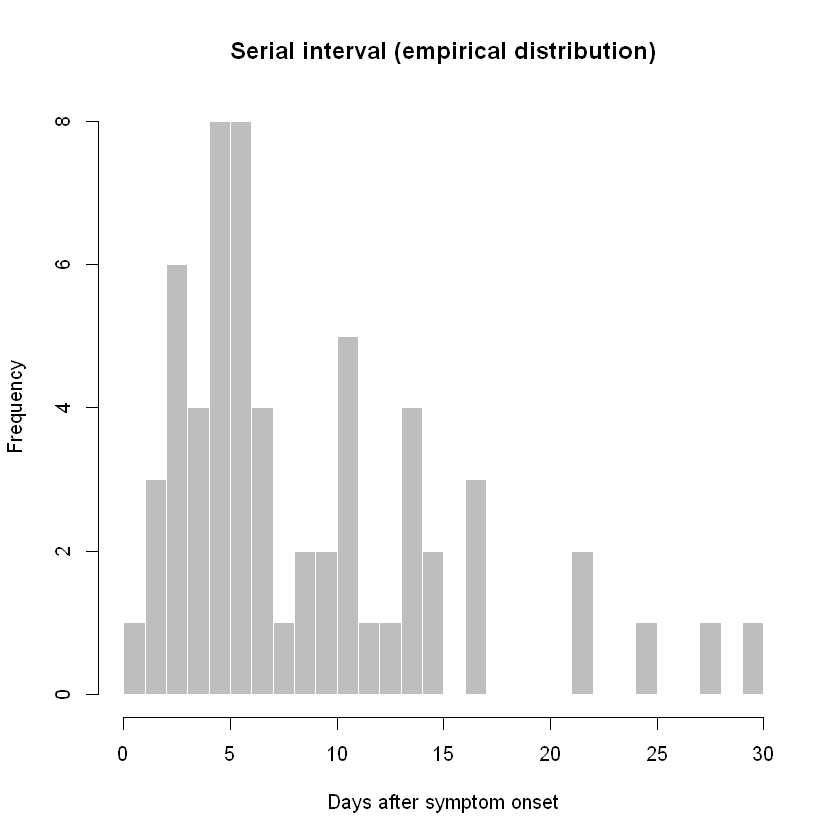

In [53]:
si_obs <- get_pairwise(epi_contacts, "date_of_onset")
summary(si_obs)
## Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
## 1.000   5.000   6.500   9.117  12.250  30.000 
hist(si_obs, breaks = 0:30,
     xlab = "Days after symptom onset", ylab = "Frequency",
     main = "Serial interval (empirical distribution)",
     col = "grey", border = "white")


What do you think of this distribution? Make any adjustment you would deem necessary, and then use the function `fit_disc_gamma` from the package `epitrix` to fit a discretised Gamma distribution to these data. Your results should approximately look like:  

In [54]:
si_fit <- fit_disc_gamma(si_obs, w = 1)
si_fit

$mu
[1] 8.614572

$cv
[1] 0.7277044

$sd
[1] 6.268862

$ll
[1] -183.4215

$converged
[1] TRUE

$distribution
A discrete distribution
  name: gamma
  parameters:
    shape: 1.88838276850863
    scale: 4.56187807520436


`si_fit` contains various information about the fitted delays, including the estimated distribution in the `$distribution` slot. You can compare this distribution to the empirical data in the following plot:

A discrete distribution
  name: gamma
  parameters:
    shape: 1.88838276850863
    scale: 4.56187807520436

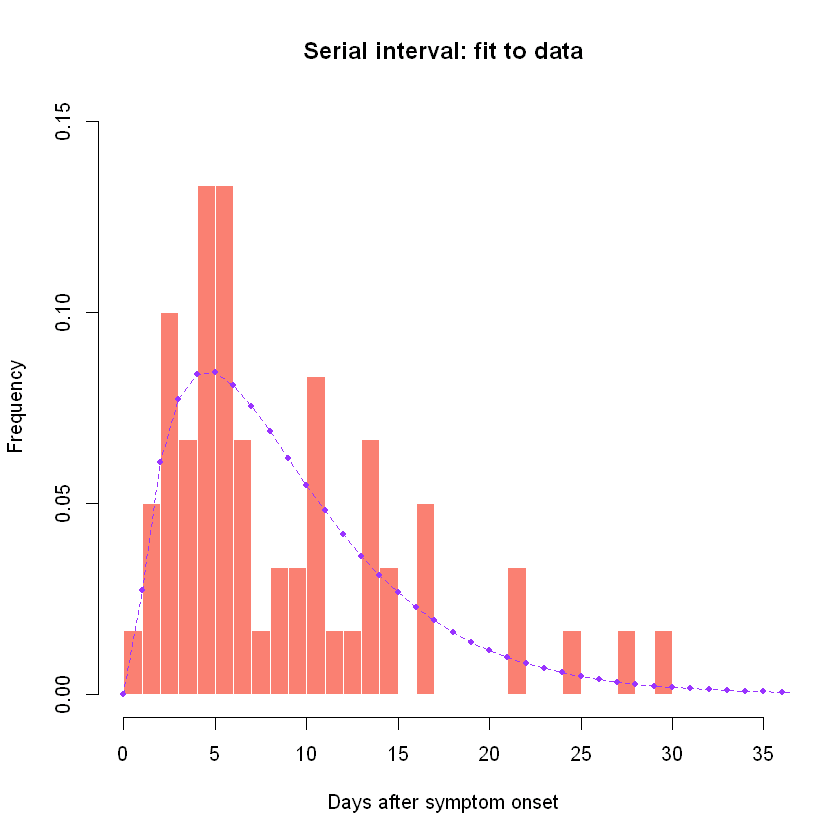

In [55]:
si <- si_fit$distribution
si

## compare fitted distribution
hist(si_obs, xlab = "Days after symptom onset", ylab = "Frequency",
     main = "Serial interval: fit to data", col = "salmon", border = "white",
     50, ylim = c(0, 0.15), freq = FALSE, breaks = 0:35)
points(0:60, si$d(0:60), col = "#9933ff", pch = 20)
points(0:60, si$d(0:60), col = "#9933ff", type = "l", lty = 2)


Would you trust this estimation of the generation time? How would you compare it to actual estimates from the West African EVD outbreak (WHO Ebola Response Team (2014) NEJM 371:1481–1495) with a mean of 15.3 days and a standard deviation 9.3 days?  

In [56]:
cat("- skewed distribution with much shorter mean than estimated in NEJM 371:1481–1495\n")  

cat("- large majority of pairs have SI <15 days\n")  

cat("- cases may remember more precisely their recent exposures which may lead to underestimation of the serial interval\n")  

cat("- when estimating the serial interval in real-time, longer serial intervals may not yet have been observed because of right censoring\n")  

cat("- this estimate is based on few observations so there is uncertainty on 
    the serial interval estimates\n")  


- skewed distribution with much shorter mean than estimated in NEJM 371:1481–1495
- large majority of pairs have SI <15 days
- cases may remember more precisely their recent exposures which may lead to underestimation of the serial interval
- when estimating the serial interval in real-time, longer serial intervals may not yet have been observed because of right censoring
- this estimate is based on few observations so there is uncertainty on 
    the serial interval estimates


### Estimation of the Reproduction Number

Now that we have estimates of the serial interval, we can use this information to estimate transmissibility of the disease (as measured by `$R_0$`). Make sure you use a daily (not weekly) incidence object truncated to the period where you have decided there is exponential growth (`i_daily_trunc`).  

Using the estimates of the mean and standard deviation of the serial interval you just obtained, use the function `estimate_R` to estimate the reproduction number  (see `?estimate_R`) and store the result in a new object `R`.  

Before using `estimate_R`, you need to create a `config` object using the `make_config` function, where you will specify the time window where you want to estimate the reproduction number as well as the `mean_si` and `std_si` to use. For the time window, use `t_start = 2` (you can only estimate R from day 2 onwards as you are conditioning on the past observed incidence) and specify `t_end = length(i_daily_trunc$counts)` to estimate R up to the last date of your truncated incidence `i_daily_trunc`.  

In [57]:

config <- make_config(mean_si = si_fit$mu, # mean of the si distribution estimated earlier
                      std_si = si_fit$sd,  # standard deviation of si dist estimated earlier
                      t_start = 2,         # starting day of time window
                      t_end = length(i_daily_trunc$counts)) # final day of time window


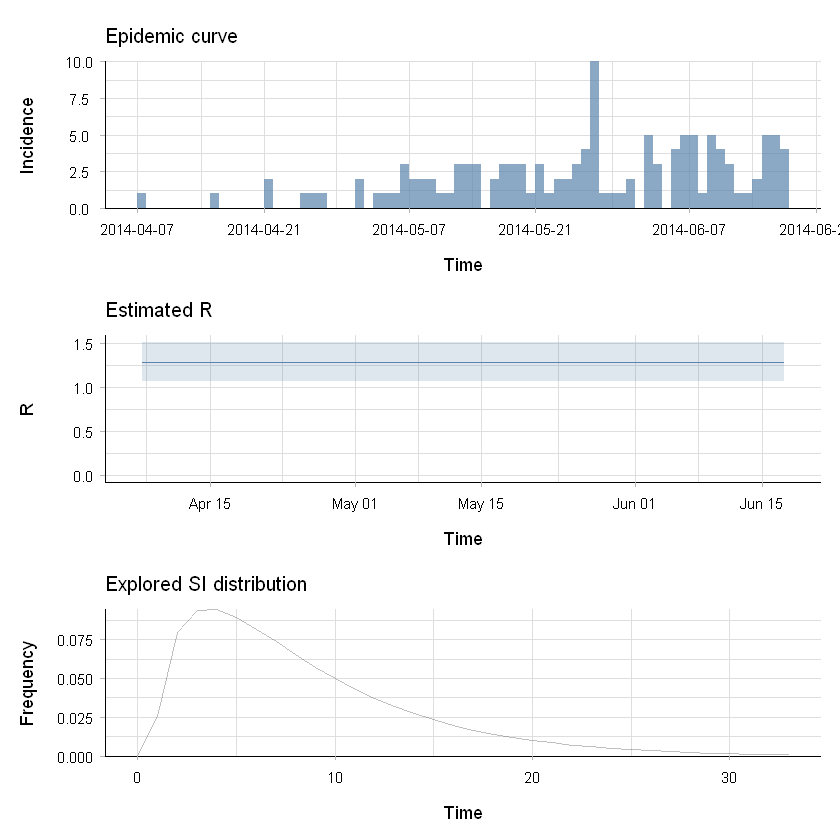

In [58]:
R <- estimate_R(i_daily_trunc, method = "parametric_si", config = config)# use estimate_R using method = "parametric_si"
plot(R, legend = FALSE)  

Extract the median and 95% credible intervals (95%CrI) for the reproduction number as follows:

In [59]:
R_median <- R$R$`Median(R)`
R_CrI <- c(R$R$`Quantile.0.025(R)`, R$R$`Quantile.0.975(R)`)
R_median
R_CrI

[1] 1.278255

[1] 1.068426 1.513913

Interpret these results: what do you make of the reproduction number? What does it reflect? Based on the last part of the epicurve, some colleagues suggest that incidence is going down and the outbreak may be under control. What is your opinion on this?

In [60]:

cat("- Note that these results are highly dependent on the estimated serial interval - a higher mean SI will lead to higher R estimates.\n")  

cat("- The results will also be sensitive to the number of data points discarded towards the end of the available data.")  


- Note that these results are highly dependent on the estimated serial interval - a higher mean SI will lead to higher R estimates.
- The results will also be sensitive to the number of data points discarded towards the end of the available data.

Note that you could have estimated R0 directly from the growth rate and the serial interval, 
using the formula described in Wallinga and Lipsitch, Proc Biol Sci, 2007: 
$$R_0 = \frac{1}{\int_{s=0}^{+\infty}e^{-rs}w(s)ds}$$ , and implemented in the function `r2R0` of the `epitrix` package. Although this may seem like a complicated formula, the reasoning behind it is simple and illustrated in the figure below: for an observed exponentially growing incidence curve, 
if you know the serial interval, you can derive the reproduction number. 

![Estimating R0 from the growth rate and the serial interval.](../static/img/R0fromr.png)

Compared to the figure above, there is uncertainty in the growth rate r, and the serial interval has a full distribution rather than a single value. This can be accounted for in estimating R as follows:

[1] 1.413491

2.5%    97.5% 
1.282404 1.567289

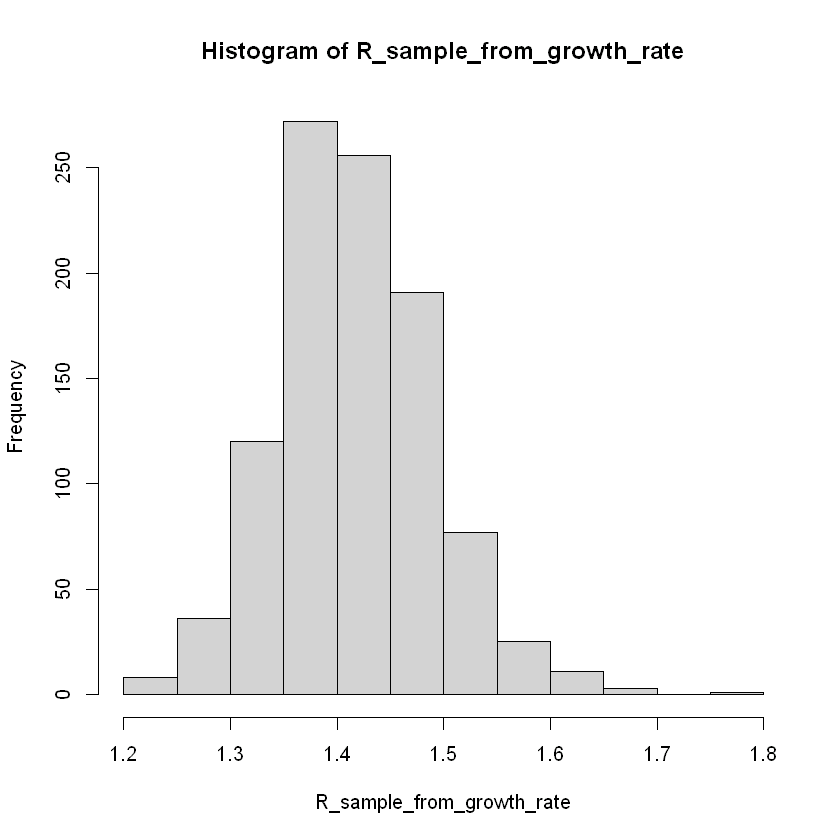

In [61]:
# generate a sample of R0 estimates from the growth rate and serial interval we estimated above 
R_sample_from_growth_rate <- lm2R0_sample(f$model, # log-linear model which contains our estimates of the growth rate r
                                          si$d(1:100), # serial interval distribution (truncated after 100 days)
                                          n = 1000) # desired sample size
# plot these:
hist(R_sample_from_growth_rate)
# what is the median?
R_median_from_growth_rate <- median(R_sample_from_growth_rate)
R_median_from_growth_rate # compare with R_median
# what is the 95%CI?
R_CI_from_growth_rate <- quantile(R_sample_from_growth_rate, c(0.025, 0.975))
R_CI_from_growth_rate # compare with R_CrI

Note the above estimates are slighlty different from those obtained using the branching process model. 
There are a few reasons for this. 
First, you used more detailed data (daily vs weekly incidence) for the branching process (EpiEstim) estimate. 
Furthermore, the log-linear model puts the same weight on all data points, whereas the branching process model puts a different weight on each data point (depending on the incidence observed at each time step). 
This may lead to slighlty different R estimates. 

## Short-term incidence forecasting  

The function `project` from the package `projections` can be used to simulate plausible epidemic trajectories by simulating daily incidence using the same branching process as the one used to estimate `$R$` in `EpiEstim`. All that is needed is one, or several values of `$R$` and a serial interval distribution, stored as a `distcrete` object.  

Here, we first illustrate how we can simulate 5 random trajectories using a fixed value of `$R$` = `r signif(R_median, 3)`, the median estimate of R from above.  
Use the same daily truncated incidence object as above to simulate future incidence.  

In [62]:
#?project
small_proj <- project(i_daily_trunc,# incidence object 
                      R = R_median, # R estimate to use
                      si = si,      # serial interval distribution
                      n_sim = 5,    # simulate 5 trajectories
                      n_days = 10,  # over 10 days
                      R_fix_within = TRUE) # keep the same value of R every day

# look at each projected trajectory (as columns):
as.matrix(small_proj)

2014-06-18,0,4,5,4,3
2014-06-19,4,3,4,3,4
2014-06-20,6,3,3,3,4
2014-06-21,5,9,3,7,0
2014-06-22,6,2,4,3,5
2014-06-23,9,3,6,7,5
2014-06-24,7,3,4,6,2
2014-06-25,3,8,4,6,8
2014-06-26,7,6,7,5,4
2014-06-27,5,6,3,3,5


In [63]:
cat("- You can either use a single  value R for the entire trajectory (R_fix_within = TRUE) or resample R at each time step (R_fix_within = FALSE).\n")  

cat("- `R_fix_within = TRUE` means that the trajectory is associated with a single R value and easier to understand\n")  

cat("- It also gives more extreme values of R and more conservative projections ")  


- You can either use a single  value R for the entire trajectory (R_fix_within = TRUE) or resample R at each time step (R_fix_within = FALSE).
- `R_fix_within = TRUE` means that the trajectory is associated with a single R value and easier to understand
- It also gives more extreme values of R and more conservative projections 

Using the same principle, generate 1,000 trajectories for the next 2 weeks, using a range of plausible values of `$R$`.  
The posterior distribution of R is gamma distributed (see Cori et al. AJE 2013) so you can use the `rgamma` function to randomly draw values from that distribution. You will also need to use the function `gamma_mucv2shapescale` from the `epitrix` package as shown below.  

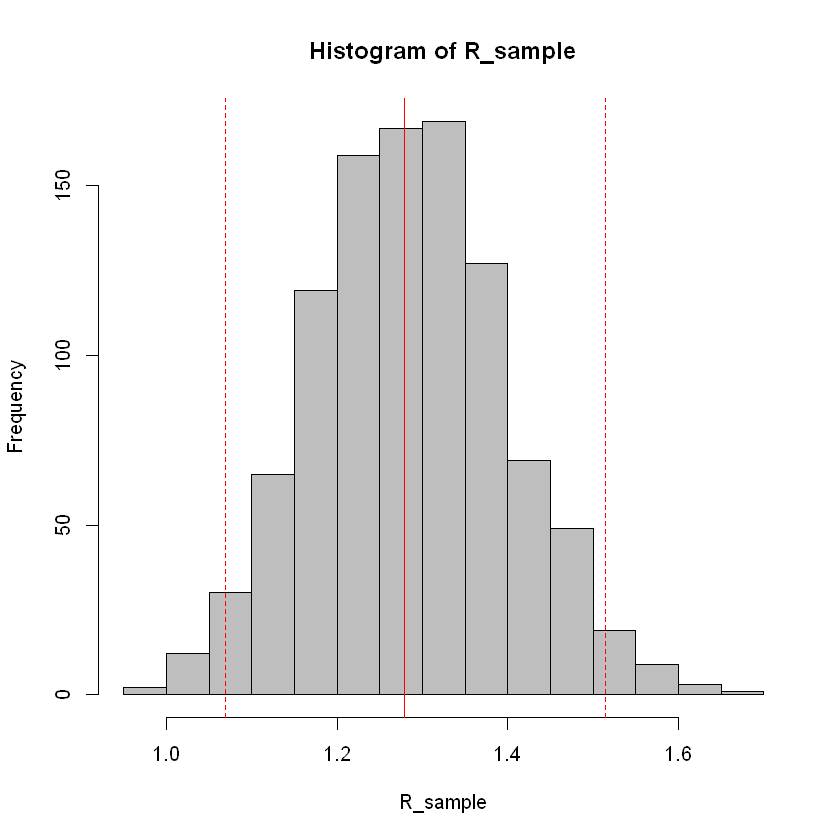

In [64]:

sample_R <- function(R, n_sim = 1000)
{
  mu <- R$R$`Mean(R)`
  sigma <- R$R$`Std(R)`
  Rshapescale <- gamma_mucv2shapescale(mu = mu, cv = sigma / mu)
  R_sample <- rgamma(n_sim, shape = Rshapescale$shape, scale = Rshapescale$scale)
  return(R_sample)
}

R_sample <- sample_R(R, 1000) # sample 1000 values of R from the posterior distribution
hist(R_sample, col = "grey")  # plot histogram of sample
abline(v = R_median, col = "red") # show the median estimated R as red solid vertical line
abline(v = R_CrI, col = "red", lty = 2) # show the 95%CrI of R as red dashed vertical lines

Store the results of your new projections in an object called `proj`.

In [65]:
proj <- project(x = i_daily_trunc, 
                R = R_sample, # now using a sample of R values
                si = si, 
                n_sim = 1000, 
                n_days = 14, # project over 2 weeks
                R_fix_within = TRUE)


You can visualise the projections as follows:  

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


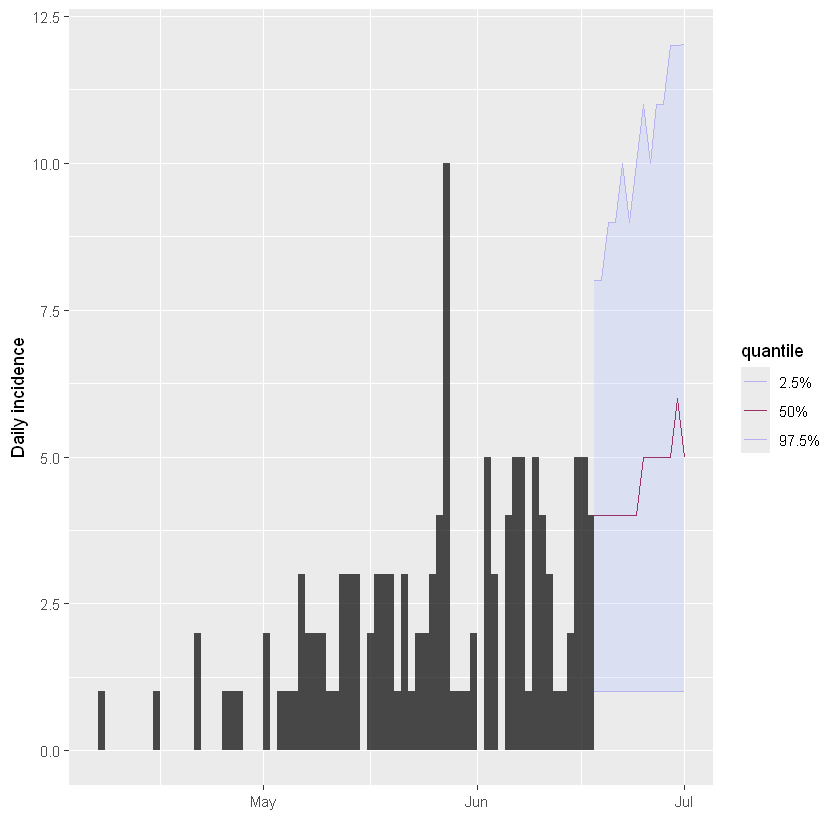

In [66]:
plot(i_daily_trunc) %>% add_projections(proj, c(0.025, 0.5, 0.975))

How would you interpret the following summary of the projections?  

In [67]:
apply(proj, 1, summary)
apply(proj, 1, function(x) mean(x > 0)) # proportion of trajectories with at least 
                                        # one case on each given day

apply(proj, 1, mean) # mean daily number of cases 

apply(apply(proj, 2, cumsum), 1, summary) # projected cumulative number of cases in 
                                          # the next two weeks

,2014-06-18,2014-06-19,2014-06-20,2014-06-21,2014-06-22,2014-06-23,2014-06-24,2014-06-25,2014-06-26,2014-06-27,2014-06-28,2014-06-29,2014-06-30,2014-07-01
Min.,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1st Qu.,2.000,3.000,3.000,3.000,3.00,3.000,3.000,3.000,3.000,3.000,3.000,4.000,4.000,4.000
Median,4.000,4.000,4.000,4.000,4.00,4.000,4.000,5.000,5.000,5.000,5.000,5.000,6.000,5.000
Mean,3.821,3.935,4.091,4.301,4.27,4.446,4.652,4.941,4.988,5.076,5.357,5.628,5.787,5.772
3rd Qu.,5.000,5.000,5.000,6.000,6.00,6.000,6.000,6.000,6.000,6.250,7.000,7.000,7.000,7.000
Max.,11.000,13.000,13.000,14.000,13.00,13.000,14.000,13.000,14.000,17.000,19.000,17.000,17.000,22.000


2014-06-18 2014-06-19 2014-06-20 2014-06-21 2014-06-22 2014-06-23 2014-06-24 
     0.980      0.980      0.980      0.981      0.985      0.982      0.981 
2014-06-25 2014-06-26 2014-06-27 2014-06-28 2014-06-29 2014-06-30 2014-07-01 
     0.988      0.986      0.989      0.996      0.991      0.993      0.991

2014-06-18 2014-06-19 2014-06-20 2014-06-21 2014-06-22 2014-06-23 2014-06-24 
     3.821      3.935      4.091      4.301      4.270      4.446      4.652 
2014-06-25 2014-06-26 2014-06-27 2014-06-28 2014-06-29 2014-06-30 2014-07-01 
     4.941      4.988      5.076      5.357      5.628      5.787      5.772

,2014-06-18,2014-06-19,2014-06-20,2014-06-21,2014-06-22,2014-06-23,2014-06-24,2014-06-25,2014-06-26,2014-06-27,2014-06-28,2014-06-29,2014-06-30,2014-07-01
Min.,0.000,1.000,3.000,4.000,5.000,7.000,9.000,12.000,15.000,18.000,20.000,22.000,26.000,27.000
1st Qu.,2.000,6.000,9.000,13.000,16.000,20.000,24.000,28.000,32.000,36.000,41.000,45.000,50.000,54.000
Median,4.000,7.000,12.000,16.000,20.000,24.000,29.000,34.000,39.000,44.000,49.000,54.000,60.000,65.000
Mean,3.821,7.756,11.847,16.148,20.418,24.864,29.516,34.457,39.445,44.521,49.878,55.506,61.293,67.065
3rd Qu.,5.000,9.000,14.000,19.000,24.000,29.000,34.000,40.000,45.250,51.000,57.000,64.000,71.000,78.000
Max.,11.000,20.000,29.000,34.000,43.000,49.000,58.000,66.000,75.000,86.000,105.000,117.000,131.000,149.000


In [68]:
cat("- `apply(proj, 1, summary)` shows a summary of incidence on each day\n")  

cat("- `apply(proj, 1, function(x) mean(x > 0))` shows  the proportion of trajectories with at least one case on each given day\n")  

cat("- `apply(proj, 1, mean)` shows the mean daily number of cases\n")  

cat("- `apply(apply(proj, 2, cumsum), 1, summary)` shows the projected additional cumulative number of cases in the next two weeks\n")  

- `apply(proj, 1, summary)` shows a summary of incidence on each day
- `apply(proj, 1, function(x) mean(x > 0))` shows  the proportion of trajectories with at least one case on each given day
- `apply(proj, 1, mean)` shows the mean daily number of cases
- `apply(apply(proj, 2, cumsum), 1, summary)` shows the projected additional cumulative number of cases in the next two weeks


According to these results, what are the chances that more cases will appear in the near future? Is this outbreak being brought under control? Would you recommend scaling up / down the response? Is this consistent with your estimate of `$R$`?
 

In [69]:
cat("- the uncertainty is wide and becomes wider the further into the future.\n")  
  
cat("- the central trend suggests increasing number of cases\n")  
  
cat("- this is based on the assumption that transmissibility has remained constant over the course of the outbreak so far and will remain constant in the future\n")  
  
cat("- all this relies on our estimated serial interval distribution---a higher mean SI would lead to larger R estimates and therefore more pessimistic incidence projections.")  

- the uncertainty is wide and becomes wider the further into the future.
- the central trend suggests increasing number of cases
- this is based on the assumption that transmissibility has remained constant over the course of the outbreak so far and will remain constant in the future
- all this relies on our estimated serial interval distribution---a higher mean SI would lead to larger R estimates and therefore more pessimistic incidence projections.

## Extra material

## Accounting for uncertainty in the serial interval estimates when estimating the reproduction number

Note that this section is independent from the following ones, please skip if you don'thave time. 

EpiEstim allows to explicitly account for the uncertainty in the serial interval estimates because of limited sample size of pairs of infector/infected individuals. Note that it also allows accounting for uncertainty on the dates of symptom onset for each of these pairs (which is not needed here). 

Use the `method = "si_from_data"` option in `estimate_R`. 
To use this option, you need to create a data frame with 4 columns: 
`EL`, `ER`, `SL` and `SR` for the left (L) and right (R) bounds of the observed time of symptoms in the infector (E) and infected (S for secondary) cases. Here we derive this from `si_obs` as follows:

In [70]:
si_data <- data.frame(EL = rep(0L, length(si_obs)), 
                      ER = rep(1L, length(si_obs)), 
                      SL = si_obs, SR = si_obs + 1L)

We can then feed this into `estimate_R` (but this will take some time to run as it estimates the serial interval distribution using an MCMC and fully accounts for the uncertainty in the serial interval to estimate the reproduction number).

Warning message in process_si_data(si_data):
"si_data contains no 'type' column. This is inferred automatically 
            from the other columns."


Running 8000 MCMC iterations 
MCMCmetrop1R iteration 1 of 8000 
function value = -186.55696
theta = 
   0.65383
   1.55628
Metropolis acceptance rate = 0.00000

MCMCmetrop1R iteration 1001 of 8000 
function value = -187.16150
theta = 
   0.74857
   1.33597
Metropolis acceptance rate = 0.56543

MCMCmetrop1R iteration 2001 of 8000 
function value = -187.85427
theta = 
   1.02485
   1.08646
Metropolis acceptance rate = 0.55722

MCMCmetrop1R iteration 3001 of 8000 
function value = -186.42488
theta = 
   0.77617
   1.37018
Metropolis acceptance rate = 0.55548

MCMCmetrop1R iteration 4001 of 8000 
function value = -186.25409
theta = 
   0.77219
   1.45212
Metropolis acceptance rate = 0.55711

MCMCmetrop1R iteration 5001 of 8000 
function value = -187.96273
theta = 
   0.47359
   1.77572
Metropolis acceptance rate = 0.55349

MCMCmetrop1R iteration 6001 of 8000 
function value = -187.16535
theta = 
   0.59059
   1.54050
Metropolis acceptance rate = 0.55207

MCMCmetrop1R iteration 7001 of 8000

[1] TRUE

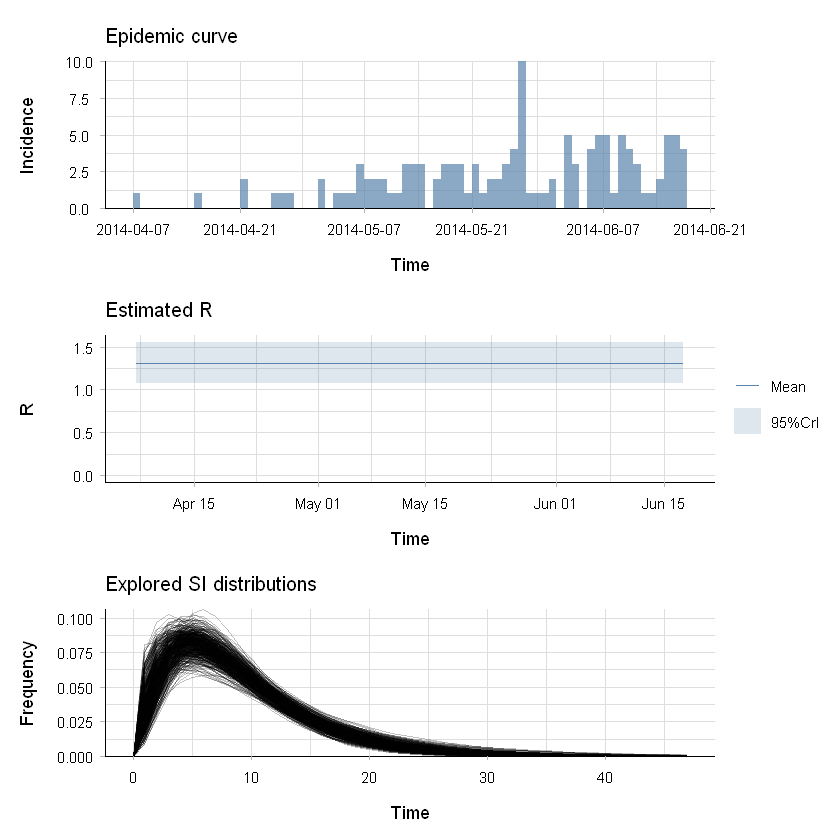

In [71]:
config <- make_config(t_start = 2, 
                      t_end = length(i_daily_trunc$counts))
R_variableSI <- estimate_R(i_daily_trunc, method = "si_from_data", 
                           si_data = si_data,
                           config = config)
# checking that the MCMC converged: 
R_variableSI$MCMC_converged
# and plotting the output:
plot(R_variableSI)

Look at the new median estimated R and 95%CrI: how different are they from your previous estimates? Do you think the size of the contacts dataset has had an impact on your results? 

In [72]:
R_variableSI_median <- R_variableSI$R$`Median(R)`
R_variableSI_CrI <- c(R_variableSI$R$`Quantile.0.025(R)`, R_variableSI$R$`Quantile.0.975(R)`)
R_variableSI_median
R_variableSI_CrI

[1] 1.299988

[1] 1.078837 1.552921

## Estimating time-varying transmissibility  

When the assumption that ($$R$$) is constant over time becomes untenable, an alternative is to estimating time-varying transmissibility using the instantaneous reproduction number ($$R_t$$). This approach, introduced by Cori et al. (2013), is also implemented in the package `EpiEstim`. It estimates ($$R_t$$) for a custom time windows (default is a succession of sliding time windows), using the same Poisson likelihood described above. In the following, we estimate transmissibility for 1-week sliding time windows (the default of `estimate_R`):  

In [73]:
config = make_config(list(mean_si = si_fit$mu, std_si = si_fit$sd))  
# t_start and t_end are automatically set to estimate R over 1-week sliding windows by default. 

In [74]:
Rt <- estimate_R(incid = i_daily_trunc,      # incidence object
                 method = "parametric_si",   # use parametric serial interval
                 config = config)            # config specified above

# look at the most recent Rt estimates:
tail(Rt$R[, c("t_start", "t_end", "Median(R)", 
             "Quantile.0.025(R)", "Quantile.0.975(R)")])

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message in estimate_R_func(incid = incid, method = method, si_sample = si_sample, :
"You're estimating R too early in the epidemic to get the desired
            posterior CV."


,t_start,t_end,Median(R),Quantile.0.025(R),Quantile.0.975(R)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
60,61,67,1.2417723,0.8144427,1.797664
61,62,68,1.0045858,0.6318551,1.501383
62,63,69,0.8405223,0.5075136,1.294892
63,64,70,1.0276681,0.6539148,1.522500
64,65,71,1.0335760,0.6576740,1.531253
65,66,72,1.0337927,0.6578119,1.531574


Plot the estimate of `$R$` over time:

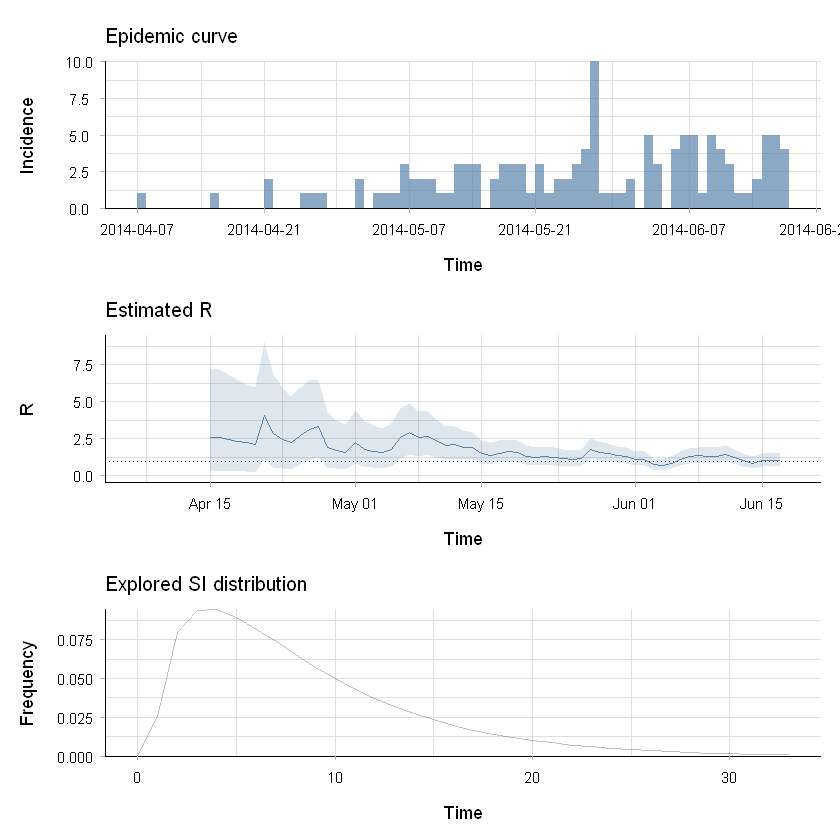

In [75]:
plot(Rt, legend = FALSE)

How would you interpret this result? What is the caveat of this representation?

What would you have concluded if instead of using `i_daily_trunc` as above, you had used the entire epidemics curve io.e. `i_daily`? 

In [76]:
Rt_whole_incid <- estimate_R(incid = i_daily, 
                             method = "parametric_si", 
                             config = config) 

tail(Rt_whole_incid$R[, c("t_start", "t_end", 
                         "Median(R)", "Quantile.0.025(R)", "Quantile.0.975(R)")])  
# the above incorrectly infers that the recent transmissibility is <1

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message in estimate_R_func(incid = incid, method = method, si_sample = si_sample, :
"You're estimating R too early in the epidemic to get the desired
            posterior CV."


,t_start,t_end,Median(R),Quantile.0.025(R),Quantile.0.975(R)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
74,75,81,1.2331123,0.8413048,1.7311193
75,76,82,1.0008620,0.6564366,1.4489075
76,77,83,0.9432483,0.6128474,1.3754184
77,78,84,0.8202432,0.5159090,1.2258778
78,79,85,0.7452619,0.4566829,1.1357051
79,80,86,0.5146162,0.2811876,0.8515137


In [77]:
cat("- the above assumes constant R within sliding time-window")  


- the above assumes constant R within sliding time-window